# Xtern Work Sample Assessment

## Submitted by: Gunveen Kaur Batra

### Task description

Given the launch of our food truck line, FoodX, we will be running an exciting and interactive promotion on college campuses to attract a massive initial student following.  When placing their order on our fancy new FoodX app they input basic information about their college experience and we predict what they are going to order.  If we don’t get it right they get a 10% discount.

While the promotion has done a great job of bringing in business our staff has not been great at guessing orders and are not happy with the combined workload of guessing and cooking.

Because of this you have been asked to consider implications, solutions and deployment of a mechanism to automatically guess orders, sounds like the perfect job for AI!

### Part 1: Data import and Visualization

In [177]:
#Importing necessary Python modules

import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [154]:
#Reading the data in

df_orders = pd.read_excel('ai_dataset.xlsx', sheet_name='Xtern_TrainData')
df_menu = pd.read_excel('ai_dataset.xlsx', sheet_name='Menu')

In [155]:
df_orders.head()

Year                    Major                University  Time  \
0  Year 2                  Physics  Indiana State University    12   
1  Year 3                Chemistry     Ball State University    14   
2  Year 3                Chemistry         Butler University    12   
3  Year 2                  Biology  Indiana State University    11   
4  Year 3  Business Administration         Butler University    12   

                                               Order  
0                               Fried Catfish Basket  
1                                    Sugar Cream Pie  
2                                 Indiana Pork Chili  
3                               Fried Catfish Basket  
4  Indiana Corn on the Cob (brushed with garlic b...

In [156]:
df_menu.head()

Unnamed: 0                              Item  Price  Calories
0           0  Hoosier BBQ Pulled Pork Sandwich      8       400
1           1            Cornbread Hush Puppies      5       250
2           2  Breaded Pork Tenderloin Sandwich      9       550
3           3                Indiana Pork Chili      7       300
4           4              Fried Catfish Basket     10       600

In [157]:
df_orders.shape, df_menu.shape

((5000, 5), (10, 4))

In [158]:
#Dropping any rows having null values

df_orders.dropna(inplace=True)
df_orders.shape

(5000, 5)

It can be observed that the data does not have any null data. 

In [159]:
df_orders.columns

Index(['Year', 'Major', 'University', 'Time', 'Order'], dtype='object')

In [160]:
#Printing statistics for each column

bold = '\033[1m'
reset = '\033[0m'
def get_information(column):
    print(bold + column + reset + '\n')
    print(df_orders[column].describe())
    print('__________________________________________________________________')
    print(df_orders[column].info())
    print('__________________________________________________________________')
    print(df_orders[column].value_counts())
    print('\n/////////////////////////////////////////////////////////////////////////////////////////\n')

for col in df_orders.columns:
    get_information(col)

Year

count       5000
unique         4
top       Year 3
freq        2719
Name: Year, dtype: object
__________________________________________________________________
<class 'pandas.core.series.Series'>
RangeIndex: 5000 entries, 0 to 4999
Series name: Year
Non-Null Count  Dtype 
--------------  ----- 
5000 non-null   object
dtypes: object(1)
memory usage: 39.2+ KB
None
__________________________________________________________________
Year
Year 3    2719
Year 2    2273
Year 1       5
Year 4       3
Name: count, dtype: int64

/////////////////////////////////////////////////////////////////////////////////////////

Major

count          5000
unique           20
top       Chemistry
freq            640
Name: Major, dtype: object
__________________________________________________________________
<class 'pandas.core.series.Series'>
RangeIndex: 5000 entries, 0 to 4999
Series name: Major
Non-Null Count  Dtype 
--------------  ----- 
5000 non-null   object
dtypes: object(1)
memory usage: 39.2+

Above I have used 3 functions - .describe(), .info() and .value_counts() to get a basic understanding about the data distributions. 

#### .describe() function 
Provides summary statistics about the numeric columns in the DataFrame or Series, such as count, mean, standard deviation, minimum, and maximum.

#### .info() function
Provides information about the data types, non-null counts, and memory usage of the series.

#### .value_counts() function 
Provides the count of unique values in the series. It is often used for categorical or discrete data to understand the distribution of values.

Important points to note from above analysis,

- The data captured spans over 4 years with the plenty of data available for year 2 and 3 (2719 and 2273 records, respectively) and very less data available for year 1 and 4 (5 and 3 records, respectively)
- We are analyzing the data for 20 majors across 10 universities for 10 items on the menu. 
- All the 10 universities being analyzed are in Indiana. 
- The distribution of orders for all the 10 items on the menu is more of less the same. 

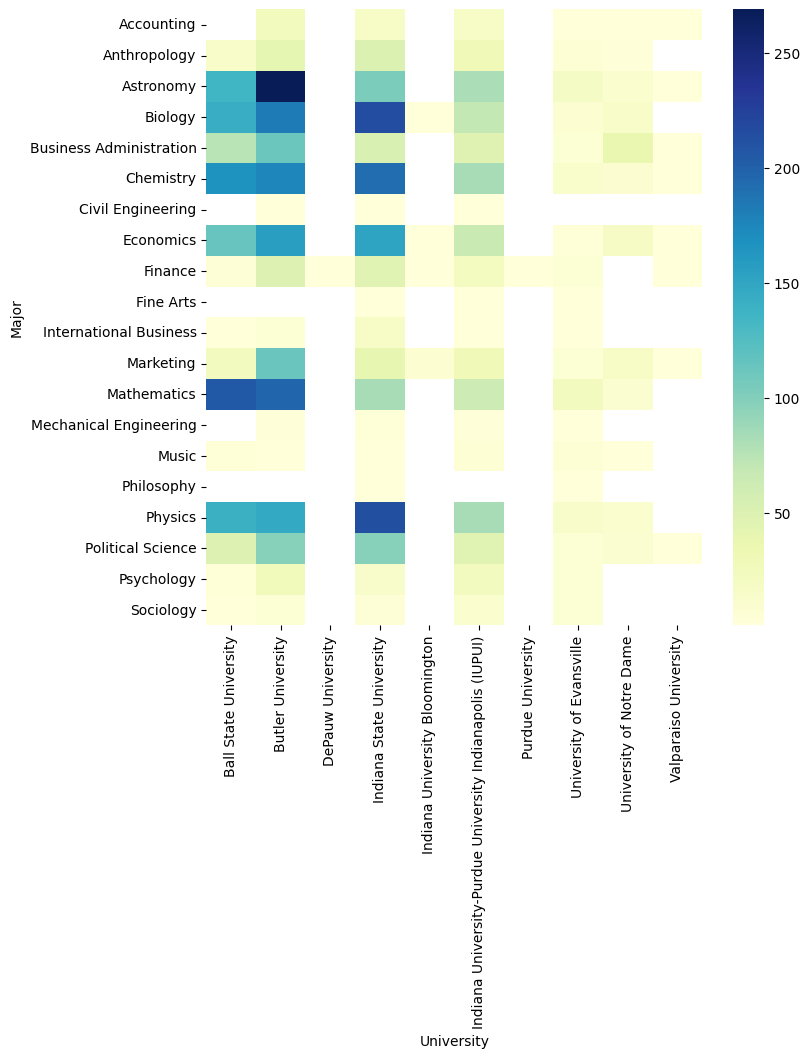

In [161]:
#Creating a heatmap of orders placed from different universities across different majors

data_uni_major_orders = pd.DataFrame({'Major':df_orders['Major'],
                                      'University':df_orders['University'],
                                      'Value':df_orders['Order']})
grouped = data_uni_major_orders.groupby(['Major','University'])['Value'].count().unstack()
plt.figure(figsize=(8, 8))
sns.heatmap(grouped, cmap='YlGnBu')
plt.xlabel('University')
plt.ylabel('Major')
plt.show()

Above diagram shows that students in 'Astronomy' major from 'Butler University' placed the highest total orders. This is indicated by the deepest blue color on the heat map. Similarly, the lighter the shade, the lesser the number of orders placed by that major from a particular university. 

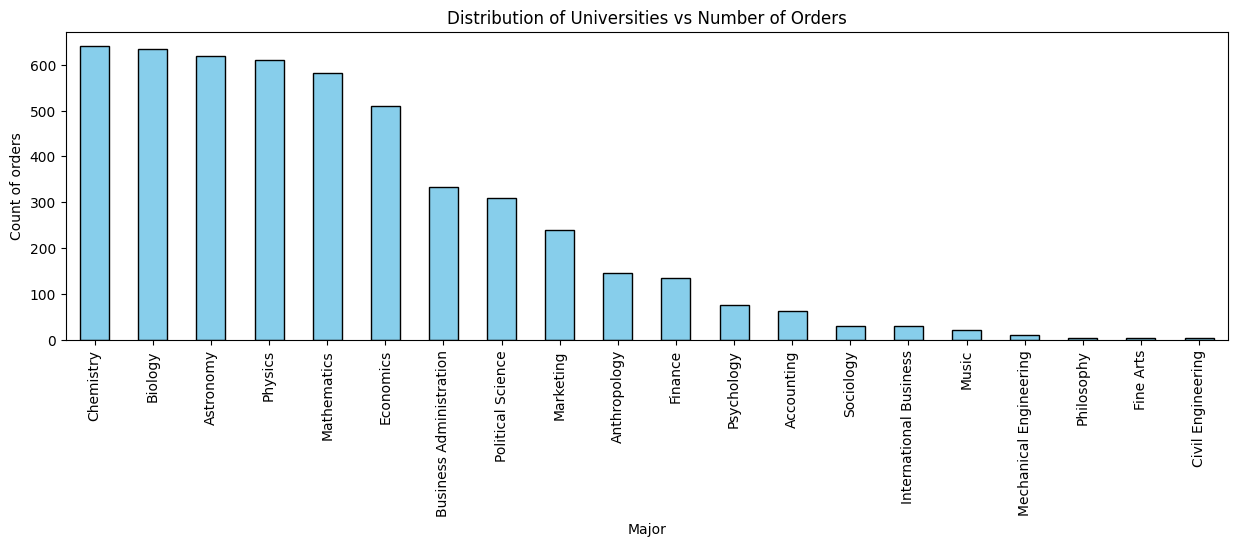

In [162]:
#Plotting a bar graph of orders across each major

plt.figure(figsize=(15, 4))
df_orders['Major'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution of Universities vs Number of Orders")
plt.xlabel("Major")
plt.ylabel("Count of orders")

plt.xticks(rotation=90)
plt.show()

From above, it can be seen that 'Chemistry' and 'Biology' majors have the highest number of orders placed across all universities, whereas 'Fine Arts' and 'Civil Engineering' have the least. 

### Part 3: Model creation and prediction

In [163]:
# Encode categorical variables (Major and University and Order)

le_major = LabelEncoder()
df_orders['Major'] = le_major.fit_transform(df_orders['Major'])
le_university = LabelEncoder()
df_orders['University'] = le_university.fit_transform(df_orders['University'])
le_year = LabelEncoder()
df_orders['Year'] = le_major.fit_transform(df_orders['Year'])
le_order = LabelEncoder()
df_orders['Order'] = le_order.fit_transform(df_orders['Order'])

In [164]:
#Shuffing the data to avoid any order bias

df_orders = shuffle(df_orders)

In [165]:
#One-hot encoding the categorical columns

categorical_cols = ['Year', 'Major', 'University']
df_orders = pd.get_dummies(df_orders, columns=categorical_cols, prefix=categorical_cols, drop_first=True)
df_orders.head()

Time  Order  Year_1  Year_2  Year_3  Major_1  Major_2  Major_3  Major_4  \
3764    13      4   False    True   False    False    False    False    False   
4648    12      7    True   False   False    False    False    False    False   
4181    13      4   False    True   False    False    False    False    False   
2657    11      1   False    True   False    False    False     True    False   
1166    13      3   False    True   False    False    False     True    False   

      Major_5  ...  Major_19  University_1  University_2  University_3  \
3764    False  ...     False         False         False          True   
4648    False  ...     False          True         False         False   
4181    False  ...     False         False         False         False   
2657    False  ...     False         False         False         False   
1166    False  ...     False         False         False          True   

      University_4  University_5  University_6  University_7  University_8  \
3764         False         False         False         False         False   
4648         False         False         False         False         False   
4181         False          True         False         False         False   
2657         False          True         False         False         False   
1166         False         False         False         False         False   

      University_9  
3764         False  
4648         False  
4181         False  
2657         False  
1166         False  

[5 rows x 33 columns]

In [166]:
#Creating training and testing datasets

X = df_orders.drop(columns=['Order'])
y = df_orders['Order']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [167]:
#Scaling the data using StandardScaler 

scaler = StandardScaler()
X_train['Time'] = scaler.fit_transform(X_train[['Time']])
X_test['Time'] = scaler.transform(X_test[['Time']])

Below shows the Scikit-Learn algorithm cheatsheet. I used below to choose the best model for my prediction task. Here is how I interpreted it,

- More than 50 samples?: YES (we have 5000 total samples, some for training and some for testing)
- Predicting a category?: YES (we are trying to predict what menu item will be placed as order)
- Do you have labeled data?: YES (orders are our labels)
- Less than 100K samples? YES (we have 5000 samples in total)

Result: Use Linear SVC

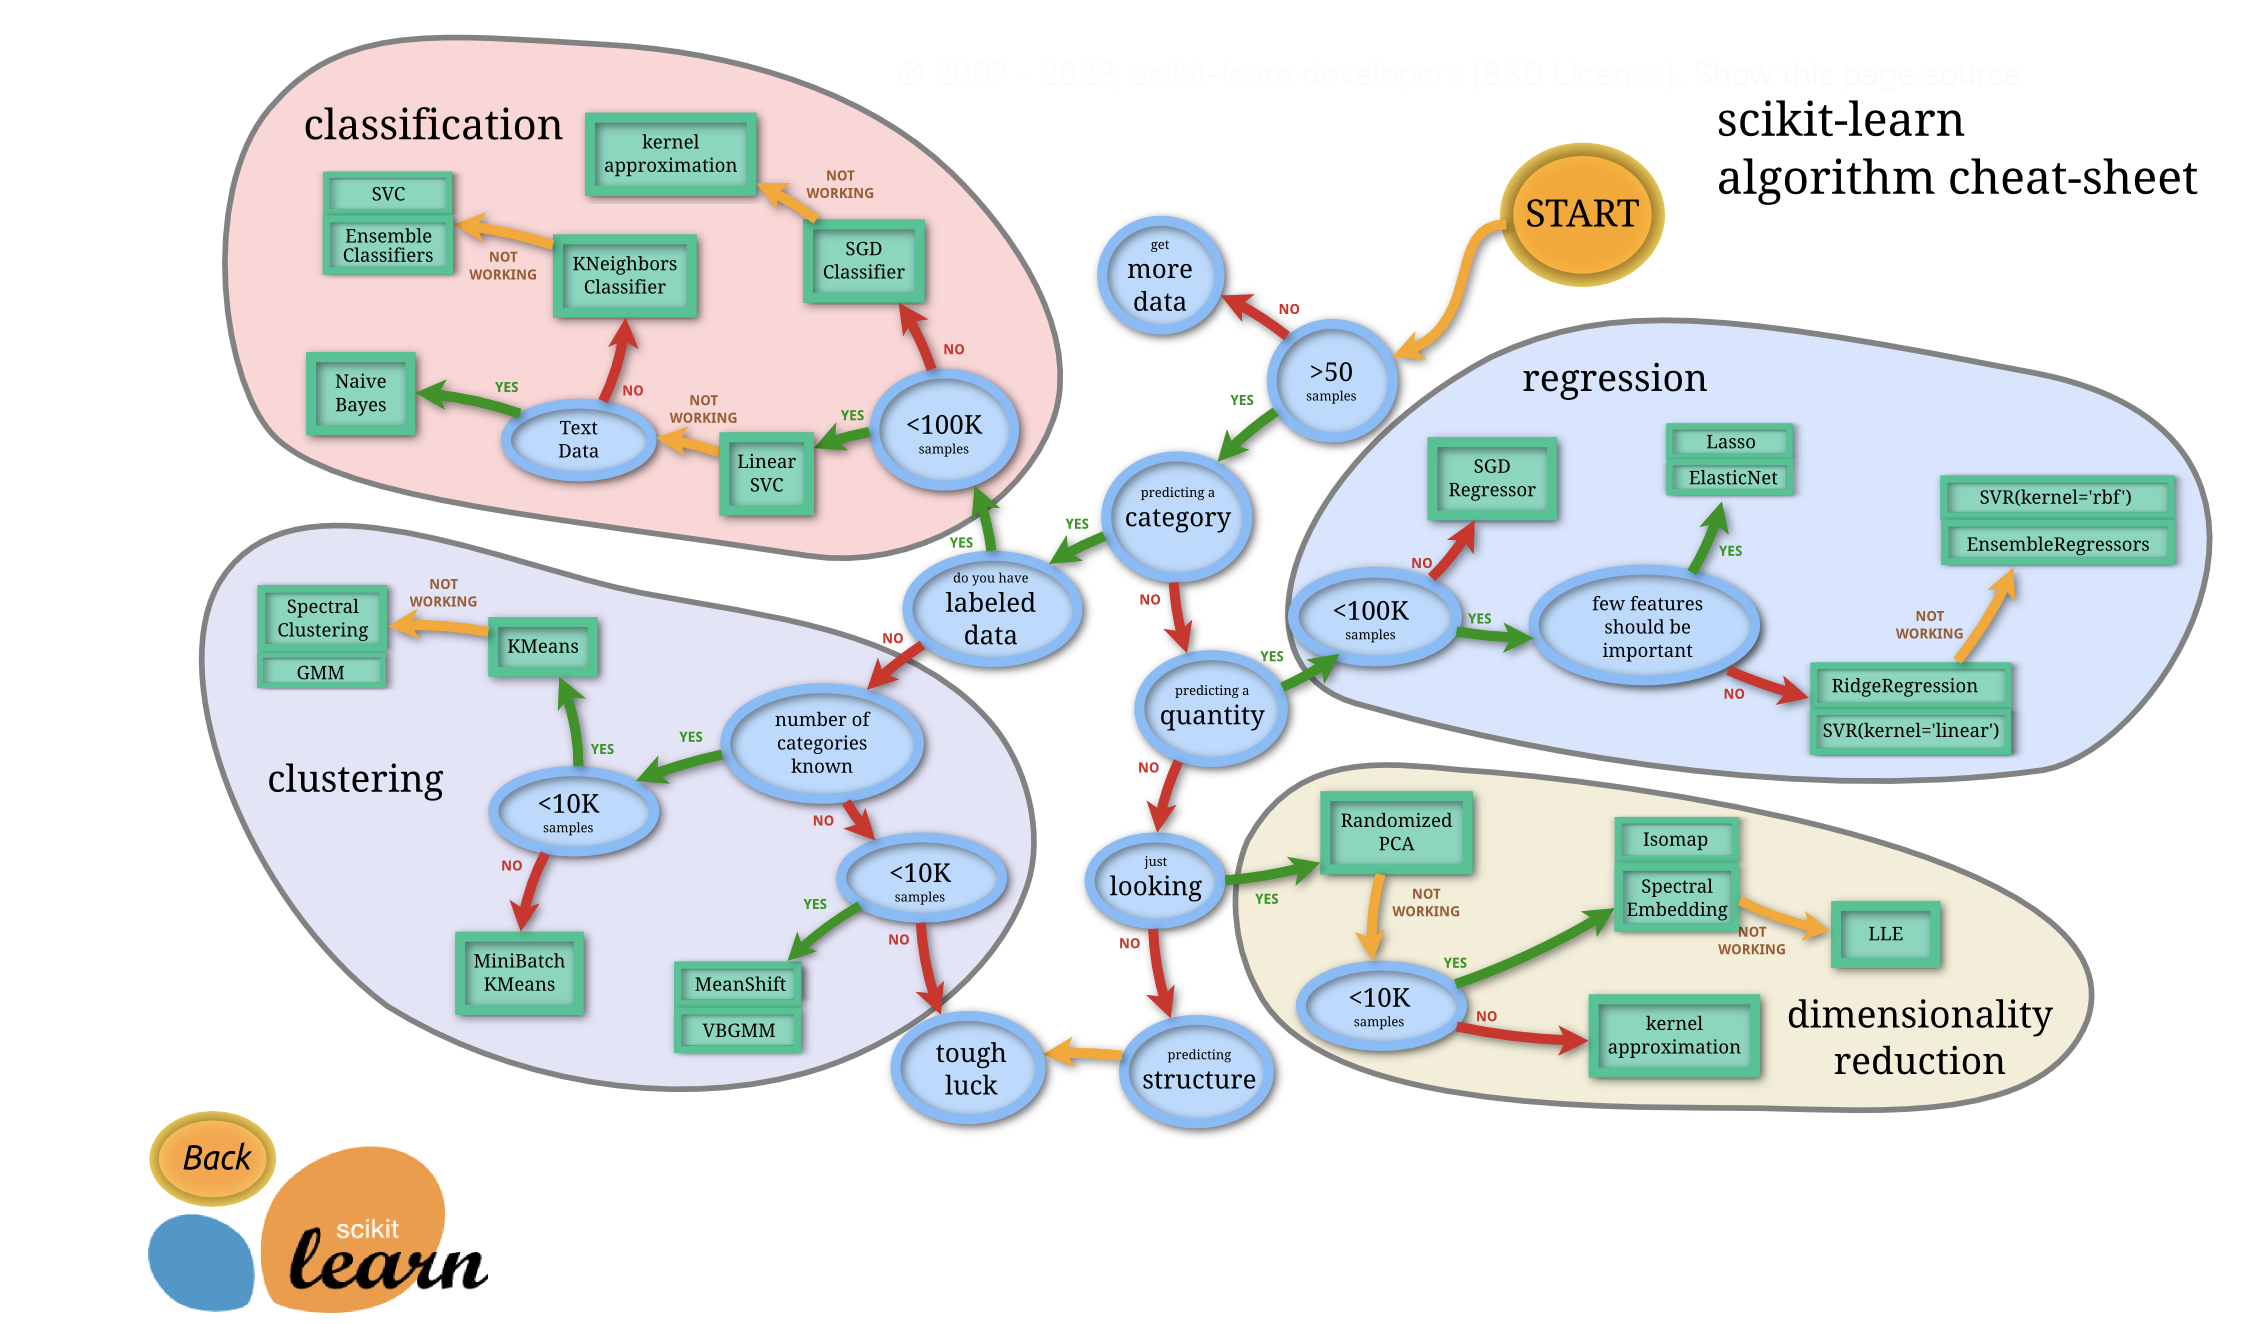

In [168]:
#Create the Support Vector Classifier

def train_svc_classifier(X_train, y_train):
    model = SVC(kernel='rbf', random_state=42)  # Radial basis function (RBF) kernel
    model.fit(X_train, y_train)
    return model

In [169]:
#Train the model

svc_classifier = train_svc_classifier(X_train, y_train)

In [170]:
#Function to evaluate the model

def evaluate_svc_classifier(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    return accuracy, report, confusion

In [171]:
#Get evaluation metrics

accuracy, report, confusion = evaluate_svc_classifier(svc_classifier, X_test, y_test)

In [172]:
# Print evaluation results

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion)

Accuracy: 0.654
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.53      0.61       108
           1       0.60      0.60      0.60        99
           2       0.68      0.57      0.62       101
           3       0.66      0.65      0.65        91
           4       0.67      0.51      0.58       100
           5       0.69      0.85      0.76       106
           6       0.75      0.86      0.80        97
           7       0.72      0.67      0.69       106
           8       0.62      0.53      0.57       110
           9       0.50      0.83      0.62        82

    accuracy                           0.65      1000
   macro avg       0.66      0.66      0.65      1000
weighted avg       0.66      0.65      0.65      1000

Confusion Matrix:
 [[57  7  4  0  2 14  3  5  0 16]
 [ 3 59  4  3 10 10  2  3  2  3]
 [ 7  5 58  4  1  2  5  0 11  8]
 [ 0  0  0 59  7  0  1  6 16  2]
 [ 1  7  1  5 51  4  2  3  5 21]
 [ 2  5  0  0  0 

Since above implemented SVC classifier using the rbf kernel gives slightly less accuracy, hence I also implemented the MLP Classifier neural network to see if I can improve the accuracy score.

In [173]:
#Create the MLP Classifier

def train_mlp_classifier(X_train, y_train):
    model = MLPClassifier(hidden_layer_sizes=(100, 75), max_iter=400, random_state=42)
    model.fit(X_train, y_train)
    return model

In [174]:
#Train the model

mlp_classifier = train_mlp_classifier(X_train, y_train)

In [175]:
#Get evaluation metrics

accuracy, report, confusion = evaluate_mlp_classifier(mlp_classifier, X_test, y_test)

In [176]:
# Print evaluation results

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion)

Accuracy: 0.674
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.49      0.58       108
           1       0.67      0.60      0.63        99
           2       0.66      0.66      0.66       101
           3       0.65      0.75      0.70        91
           4       0.71      0.52      0.60       100
           5       0.70      0.90      0.79       106
           6       0.82      0.84      0.83        97
           7       0.70      0.67      0.69       106
           8       0.61      0.52      0.56       110
           9       0.55      0.87      0.67        82

    accuracy                           0.67      1000
   macro avg       0.68      0.68      0.67      1000
weighted avg       0.68      0.67      0.67      1000

Confusion Matrix:
 [[53  8  9  1  2 14  3  6  0 12]
 [ 1 59  3  5  7 13  3  3  2  3]
 [ 5  2 67  2  4  2  5  0 10  4]
 [ 0  0  0 68  3  0  0  5 13  2]
 [ 4  7  0  8 52  3  0  3  6 17]
 [ 1  1  0  0  0 

From above it can be observed that MLP Classifier outperforms the SVC classifier by 2%. Implementation of random forest classfier and XGBoost techniques can also be done as future work for this problem. 

In [178]:
#Function to pickle the model file

def save_model_to_pickle(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [179]:
save_model_to_pickle(svc_classifier, 'model_svc.pkl')
save_model_to_pickle(mlp_classifier, 'model_mlp.pkl')

### Part 2: Discussing implications of data collection, storage, and data biases

Collecting personal data like Year, Major, and University should be done with informed consent and should comply with privacy laws and regulations. Users should be aware of the data being collected. Mishandling personal data can damage the organization's reputation, leading to loss of trust and customers. It is highly critical to safeguard the data to protect it from unauthorized access or breaches that could result in the exposure of personal information. Data accuracy and consistency must be maintained to make meaningful decisions and avoid misinterpretation. Below lists the ethical, business outcome and tecnical implications of data collection, data storage and data biases,

### Data Collection

   **Ethical Implications**:
   - *Transparency*: Data collection practices and purposes must be clearly communicated to users.
   - *Consent*: Data collection informed consent should be obtained and be transparency must be maintained on how the data will be used.

   **Business Outcome Implications**:
   - *Customer Satisfaction*: Transparent data collection practices will always enhance customer trust and satisfaction which will in-turn lead to improved business trajectory.
   - *Legal Compliance*: Complying with data protection regulations will help avoid legal troubles.

   **Technical Implications**:
   - *Data Storage*: Data must be properly stored in a secure and accessible manner.
   - *Data Retention Policies*: Data retention policies must be implemented to manage data throughout its lifecycle.
   

### Data Storage

   **Ethical Implications**:
   - *Data Security*: Data needs to be safeguarded to protect it from breaches that could expose sensitive information.
   - *Data Ownership*: It should be very clear about who owns the data and who can access it.

   **Business Outcome Implications**:
   - *Data Access and Availability*: Data must be made available to authorized personnel when needed.
   - *Data Backup and Recovery*: Data backup and recovery procedures must be put in place to prevent data loss.

   **Technical Implications**:
   - *Data Management*: Databases, storage solutions, and access controls must be used to manage data effectively.
   - *Data Encryption*: Sensitive data at rest and in transit must be encrypted to maintain confidentiality.

### Data Biases

   **Ethical Implications**:
   - *Fairness*: Analyze data to be aware of potential biases in data collection and ensure fairness in decision-making processes.

   **Business Outcome Implications**:
   - *Unbiased Decisions*: Bias in data must be reduced to obtain more accurate and equitable business decisions.

   **Technical Implications**:
   - *Bias Detection and Mitigation*: Algorithms and techniques must be implemented to detect and mitigate bias in data and models.
   - *Model Explainability*: Models that provide transparency and explainability to understand how decisions are made must be implemented.

Addressing these ethical, business, and technical considerations can help responsibly and effectively collect, store, and analyze data, while also building trust with stakeholders and minimizing potential negative consequences.

### Part 4: Given the work required to bring a solution like this to maturity and its performance, what considerations would you make to determine if this is a suitable course of action?

I believe the following points should be taken into consideration when designing a system like this,

- *Data Quality and Availability*: It is critical to assess the quality and availability of data. Developers musy ensure that the data used for training and testing is representative, accurate, and up-to-date. 
- *Performance Metrics*: The model's performance metrics (e.g., accuracy, precision, recall, F1-score) must be monitored and imporved continously to determine how well it meets the desired objectives. 
- *Maintenance and Monitoring*: The need and procedure to maintain and monitor should be kept in mind when designing a system like this. 
- *Risk Assessment*: It is recommended to identify potential risks and mitigation strategies. This includes technical risks (e.g., model failures), legal risks (e.g., data privacy), and business risks (e.g., market changes) before putting a solution like this into production. 
- *Long-Term Viability*: Consider the long-term viability of the solution. Is the technology used in the solution likely to remain relevant in the future? Can the model adapt to changing circumstances?